In [4]:
import os
import json
import cv2
import numpy as np
import random
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2,DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
#from google.colab.patches import cv2_imshow


# Preparação de Dados

A base de dados PKLot possui a seguinte estrutura:
 - PUC
 - UFPR04
 - UFPR05

Cada uma dessas pastas possui mais 3 pastas, Cloudy, Rainy e Sunny
Dentro dessas pastas de clima, existem pastas separadas por datas e dentro de cada uma dessas varias imagens de estacionamento com um XML, indicando onde na imagem existe uma vaga e se ela esta ocupada ou não.

In [5]:
def prepare_dataset(dataset_path):
  weather_labels = {'Rainy': 0, 'Sunny': 1, 'Cloudy': 2}
  locations = ['PUC', 'UFPR04', 'UFPR05']
  rainy_images = []
  sunny_images = []
  cloudy_images = []

  for weather, label in weather_labels.items():
    for location in locations:
      for root, _, files in os.walk(os.path.join(dataset_path, location, weather)):
        sampled_files = random.sample(files, int(0.25 * len(files)))
        for file in sampled_files:
          if file.endswith('.jpg'):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            img = img_to_array(img)
            if weather == 'Rainy':
              rainy_images.append([img, label, img_path])
            elif weather == 'Sunny':
              sunny_images.append([img, label, img_path])
            elif weather == 'Cloudy':
              cloudy_images.append([img, label, img_path])

  return np.array(rainy_images, dtype=object), np.array(sunny_images, dtype=object), np.array(cloudy_images, dtype=object)

In [6]:
# Example usage
dataset_path = 'D:\\PKLot (1)\\PKLot'
rainy_data, sunny_data, cloudy_data = prepare_dataset(dataset_path)

In [7]:
print(rainy_data.shape)
print(sunny_data.shape)
print(cloudy_data.shape)

(127, 3)
(1165, 3)
(686, 3)


# Cria vetores de treinamento para MobileNet e DenseNet

In [8]:
weather_data = np.concatenate((rainy_data, sunny_data, cloudy_data))

np.random.shuffle(weather_data)

# Extrair as imagens e labels
weather_images = np.array([item[0] for item in weather_data])
weather_labels = np.array([item[1] for item in weather_data])
weather_paths = np.array([item[2] for item in weather_data])

In [9]:
weather_labels

array([2, 1, 1, ..., 2, 2, 1])

# Modelo (Transfer Learning com MobileNetV2)

In [10]:
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [11]:
for layer in mobilenet_model.layers:
  layer.trainable = False

In [12]:
mobilenet_output = GlobalAveragePooling2D()(mobilenet_model.output)
mobilenet_model = Model(inputs=mobilenet_model.input, outputs=mobilenet_output)
mobilenet_features = mobilenet_model.predict(weather_images)


62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 362ms/step




# Modelo (Transfer Learning com DenseNet)


In [13]:
densenet_model = tf.keras.applications.DenseNet121(input_shape=(224,224, 3),
                                                   include_top=False,
                                                   weights="imagenet")

In [14]:
for layer in densenet_model.layers:
  layer.trainable = False

In [15]:
densenet_output = GlobalAveragePooling2D()(densenet_model.output)
densenet_model = Model(inputs=densenet_model.input, outputs=densenet_output)
densenet_features = densenet_model.predict(weather_images)

62/62 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step


# Combined Features

In [16]:
combined_features = np.concatenate([mobilenet_features, densenet_features], axis=-1)

# Crie e treine o classificador KNN

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, weather_labels, test_size=0.2, random_state=42
)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [18]:
accuracy = knn.score(X_test, y_test)
print(f"Acurácia do KNN: {accuracy}")

Acurácia do KNN: 0.9217171717171717


In [19]:
predictions = knn.predict(X_train)

image_predictions = [[prediction, image_path] for prediction, image_path in zip(predictions, weather_paths)]

# Separando Predição do KNN para cada Clima

In [22]:
rainy_predictions = []
cloudy_predictions = []
sunny_predictions = []

for i in range(len(image_predictions)):
    xml_path = image_predictions[i][1].replace('.jpg', '.xml')
    if image_predictions[i][0] == 0:
        rainy_predictions.append([image_predictions[i][1], xml_path])
    elif image_predictions[i][0] == 1:
        sunny_predictions.append([image_predictions[i][1], xml_path])
    elif image_predictions[i][0] == 2:
        cloudy_predictions.append([image_predictions[i][1], xml_path])

print(len(rainy_predictions))
print(len(sunny_predictions))
print(len(cloudy_predictions))

100
906
576


In [23]:
rainy_images = [item[0] for item in rainy_predictions]
rainy_xmls = [item[1] for item in rainy_predictions]

sunny_images = [item[0] for item in sunny_predictions]
sunny_xmls = [item[1] for item in sunny_predictions]

cloudy_images = [item[0] for item in cloudy_predictions]
cloudy_xmls = [item[1] for item in cloudy_predictions]

# Extração de vagas do XML para treinamento das ResNet's especializadas

In [24]:
def extrair_vagas(caminho_imagem, caminho_xml):
    imagem = cv2.imread(caminho_imagem)

    tree = ET.parse(caminho_xml)
    root = tree.getroot()

    vagas = []
    rotulos = []
    coords = []

    for space in root.findall('space'):
        ocupado = int(space.attrib.get('occupied', 0))  # 0 = livre, 1 = ocupada

        pontos = []

        contour = space.find('contour')
        if contour is not None:
            pontos_tags = contour.findall('point') or contour.findall('Point')  # busca 'point' ou 'Point'

            for point in pontos_tags:
                x = int(point.attrib['x'])
                y = int(point.attrib['y'])
                pontos.append([x, y])

        if not pontos:
            continue

        pontos = np.array(pontos, dtype=np.int32)

        mask = np.zeros_like(imagem)
        cv2.fillPoly(mask, [pontos], (255, 255, 255))

        vaga = cv2.bitwise_and(imagem, mask)

        rect = cv2.boundingRect(pontos)
        x, y, w, h = rect
        coords.append((x, y, w, h))
        vaga_recortada = vaga[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]

        vaga_recortada = cv2.resize(vaga_recortada, (128, 128))

        vagas.append(vaga_recortada)
        rotulos.append(ocupado)

    estacionamento = (imagem, np.array(vagas), np.array(rotulos), np.array(coords))
    return estacionamento

In [26]:
def extrair_vagas_multiplas(imagens, xmls):
  images = []
  vagas = []
  rotulos = []
  coords = []
  for img, xml in zip(imagens, xmls):
    (image_temp, vagas_temp, rotulos_temp, coord_temp) = extrair_vagas(img, xml)
    images.append(image_temp)
    vagas.extend(vagas_temp)
    rotulos.extend(rotulos_temp)
    coords.extend(coord_temp)
  return images, vagas, rotulos, coords

In [27]:
park_rainy_images, rainy_vagas, rainy_labels, rainy_coords = extrair_vagas_multiplas(rainy_images, rainy_xmls)
park_sunny_images, sunny_vagas, sunny_labels, sunny_coords = extrair_vagas_multiplas(sunny_images, sunny_xmls)
park_cloudy_images, cloudy_vagas, cloudy_labels, cloudy_coords = extrair_vagas_multiplas(cloudy_images, cloudy_xmls)

In [30]:
rainy_vagas = np.array(rainy_vagas)
rainy_labels = np.array(rainy_labels)
rainy_coords = np.array(rainy_coords)

sunny_vagas = np.array(sunny_vagas)
sunny_labels = np.array(sunny_labels)
sunny_coords = np.array(sunny_coords)

cloudy_vagas = np.array(cloudy_vagas)
cloudy_labels = np.array(cloudy_labels)
cloudy_coords = np.array(cloudy_coords)

# Criação das ResNet's

In [31]:
def create_resnet50_model(num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False

    inputs = layers.Input(shape=(128, 128, 3))

    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    return model

In [32]:
num_classes = 2
model_rainy = create_resnet50_model(num_classes)

model_rainy.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_rainy.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [33]:
num_classes = 2
model_sunny = create_resnet50_model(num_classes)

model_sunny.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_sunny.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [34]:
num_classes = 2
model_cloudy = create_resnet50_model(num_classes)

model_cloudy.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_cloudy.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Separação de dados por clima, para treinamento das ResNet's

In [62]:
rainy_originais = np.arange(len(rainy_vagas))
sunny_originais = np.arange(len(sunny_vagas))
cloudy_originais = np.arange(len(cloudy_vagas))


rainy_vagas_treino, rainy_vagas_teste, rainy_labels_treino, rainy_labels_teste, rainy_indices_train, rainy_indices_test = train_test_split(rainy_vagas, rainy_labels, rainy_originais,test_size=0.2, random_state=42)
sunny_vagas_treino, sunny_vagas_teste, sunny_labels_treino, sunny_labels_teste,sunny_indices_train, sunny_indices_test = train_test_split(sunny_vagas, sunny_labels,sunny_originais, test_size=0.2, random_state=42)
cloudy_vagas_treino, cloudy_vagas_teste, cloudy_labels_treino, cloudy_labels_teste,cloudy_indices_train, cloudy_indices_test = train_test_split(cloudy_vagas, cloudy_labels,cloudy_originais, test_size=0.2, random_state=42)

# Treinamento das ResNet's

In [39]:
rainy_history = model_rainy.fit(rainy_vagas_treino, rainy_labels_treino, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 431ms/step - accuracy: 0.8162 - loss: 2.0624 - val_accuracy: 0.9963 - val_loss: 0.0181
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.9875 - loss: 0.0517 - val_accuracy: 0.9870 - val_loss: 0.0243
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 398ms/step - accuracy: 0.9894 - loss: 0.0240 - val_accuracy: 0.9852 - val_loss: 0.0433
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 407ms/step - accuracy: 0.9896 - loss: 0.0241 - val_accuracy: 0.9981 - val_loss: 0.0104
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 395ms/step - accuracy: 0.9948 - loss: 0.0149 - val_accuracy: 0.9778 - val_loss: 0.0356
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 400ms/step - accuracy: 0.9907 - loss: 0.0285 - val_accuracy: 0.9907 - val_loss: 0.0211
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 396ms/step - accuracy: 0.9898 - loss: 0.0335 - val_accuracy: 0.9907 - val_loss: 0.0251
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - accuracy: 0.9975 - loss: 0.0092 - val_accu

In [40]:
sunny_history = model_sunny.fit(sunny_vagas_treino, sunny_labels_treino, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 255s 403ms/step - accuracy: 0.9681 - loss: 0.1507 - val_accuracy: 0.9950 - val_loss: 0.0311
Epoch 2/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 246s 396ms/step - accuracy: 0.9929 - loss: 0.0346 - val_accuracy: 0.9966 - val_loss: 0.0186
Epoch 3/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 245s 395ms/step - accuracy: 0.9946 - loss: 0.0220 - val_accuracy: 0.9964 - val_loss: 0.0266
Epoch 4/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 234s 376ms/step - accuracy: 0.9941 - loss: 0.0226 - val_accuracy: 0.9972 - val_loss: 0.0210
Epoch 5/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 234s 377ms/step - accuracy: 0.9956 - loss: 0.0213 - val_accuracy: 0.9974 - val_loss: 0.0187
Epoch 6/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 229s 369ms/step - accuracy: 0.9954 - loss: 0.0201 - val_accuracy: 0.9972 - val_loss: 0.0178
Epoch 7/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 229s 368ms/step - accuracy: 0.9964 - loss: 0.0164 - val_accuracy: 0.9960 - val_loss: 0.0179
Epoch 8/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 244s 393ms/step - accuracy: 0.9978 -

In [41]:
cloudy_history = model_cloudy.fit(cloudy_vagas_treino, cloudy_labels_treino, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 159s 395ms/step - accuracy: 0.9613 - loss: 0.2222 - val_accuracy: 0.9955 - val_loss: 0.0351
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 153s 389ms/step - accuracy: 0.9914 - loss: 0.0495 - val_accuracy: 0.9908 - val_loss: 0.0502
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 153s 389ms/step - accuracy: 0.9944 - loss: 0.0256 - val_accuracy: 0.9962 - val_loss: 0.0317
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 153s 390ms/step - accuracy: 0.9914 - loss: 0.0624 - val_accuracy: 0.9971 - val_loss: 0.0341
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 151s 386ms/step - accuracy: 0.9966 - loss: 0.0190 - val_accuracy: 0.9955 - val_loss: 0.0366
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 152s 388ms/step - accuracy: 0.9961 - loss: 0.0210 - val_accuracy: 0.9965 - val_loss: 0.0276
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 152s 387ms/step - accuracy: 0.9946 - loss: 0.0241 - val_accuracy: 0.9968 - val_loss: 0.0265
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 153s 389ms/step - accuracy: 0.9949 -

# Accuracy ResNet Clima Rainy (chuvoso)

In [42]:
loss_rainy, accuracy_rainy = model_rainy.evaluate(rainy_vagas_teste, rainy_labels_teste)
print(f"Loss: {loss_rainy:.4f}")
print(f"Accuracy: {accuracy_rainy:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step - accuracy: 0.9982 - loss: 0.0054
Loss: 0.0053
Accuracy: 0.9985


# Accuracy ResNet Clima Sunny (Ensolarado)

In [43]:
loss_sunny, accuracy_sunny = model_sunny.evaluate(sunny_vagas_teste, sunny_labels_teste)
print(f"Loss: {loss_sunny:.4f}")
print(f"Accuracy: {accuracy_sunny:.4f}")

194/194 ━━━━━━━━━━━━━━━━━━━━ 59s 306ms/step - accuracy: 0.9946 - loss: 0.0524
Loss: 0.0294
Accuracy: 0.9958


# Accuracy ResNet Clima Cloudy (Nublado)

In [44]:
loss_cloudy, accuracy_cloudy = model_cloudy.evaluate(cloudy_vagas_teste, cloudy_labels_teste)
print(f"Loss: {loss_cloudy:.4f}")
print(f"Accuracy: {accuracy_cloudy:.4f}")

123/123 ━━━━━━━━━━━━━━━━━━━━ 38s 308ms/step - accuracy: 0.9958 - loss: 0.0608
Loss: 0.0424
Accuracy: 0.9957


# Matriz de Confusão de cada ResNet Especializada

In [45]:
#predict rainy
y_pred_rainy = model_rainy.predict(rainy_vagas_teste)
y_pred_rainy_classes = np.argmax(y_pred_rainy, axis=1) 

#predict sunny
y_pred_sunny = model_sunny.predict(sunny_vagas_teste)
y_pred_sunny_classes = np.argmax(y_pred_sunny, axis=1)

#predict cloudy
y_pred_cloudy = model_cloudy.predict(cloudy_vagas_teste)
y_pred_cloudy_classes = np.argmax(y_pred_cloudy, axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 61s 309ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 40s 313ms/step


# Matrix de confusão Rainy (Chuvoso)

In [46]:
print(classification_report(rainy_labels_teste, y_pred_rainy_classes))

rainy_conf_matrix = confusion_matrix(rainy_labels_teste, y_pred_rainy_classes)
print("Matriz de Confusão - Rainy:")
print(rainy_conf_matrix)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       295
           1       1.00      1.00      1.00       381

    accuracy                           1.00       676
   macro avg       1.00      1.00      1.00       676
weighted avg       1.00      1.00      1.00       676

Matriz de Confusão - Rainy:
[[294   1]
 [  0 381]]


# Matrix de confusão Sunny (Ensolarado)

In [47]:
print(classification_report(sunny_labels_teste, y_pred_sunny_classes))
sunny_conf_matrix = confusion_matrix(sunny_labels_teste, y_pred_sunny_classes)
print("Matriz de Confusão - sunny:")
print(sunny_conf_matrix)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3032
           1       0.99      1.00      1.00      3175

    accuracy                           1.00      6207
   macro avg       1.00      1.00      1.00      6207
weighted avg       1.00      1.00      1.00      6207

Matriz de Confusão - sunny:
[[3012   20]
 [   6 3169]]


# Matrix de confusão Cloudy (Nublado)

In [48]:
print(classification_report(cloudy_labels_teste, y_pred_cloudy_classes))
cloudy_conf_matrix = confusion_matrix(cloudy_labels_teste, y_pred_cloudy_classes)
print("Matriz de Confusão - cloudy:")
print(cloudy_conf_matrix)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1867
           1       1.00      0.99      1.00      2060

    accuracy                           1.00      3927
   macro avg       1.00      1.00      1.00      3927
weighted avg       1.00      1.00      1.00      3927

Matriz de Confusão - cloudy:
[[1863    4]
 [  13 2047]]


# Gráficos de Loss e Acuracy Rainy

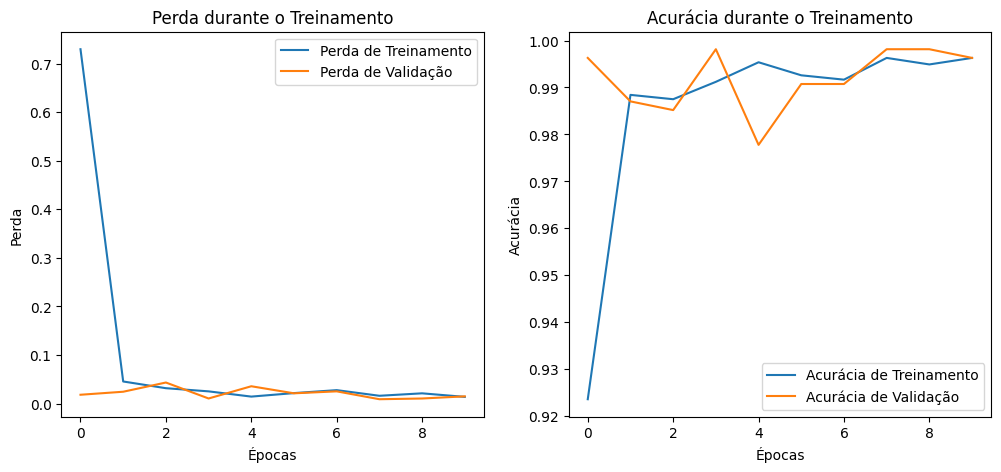

In [49]:
# Plotando a perda
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rainy_history.history['loss'], label='Perda de Treinamento')
plt.plot(rainy_history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Plotando a precisão
plt.subplot(1, 2, 2)
plt.plot(rainy_history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(rainy_history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

# Gráficos de Loss e Acuracy Sunny

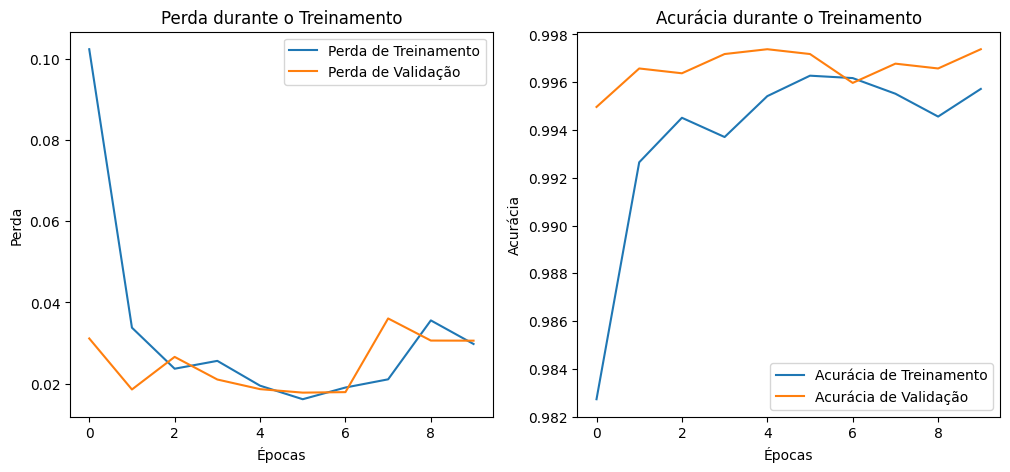

In [50]:
# Plotando a perda
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sunny_history.history['loss'], label='Perda de Treinamento')
plt.plot(sunny_history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Plotando a precisão
plt.subplot(1, 2, 2)
plt.plot(sunny_history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(sunny_history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

# Gráficos de Loss e Acuracy Cloudy

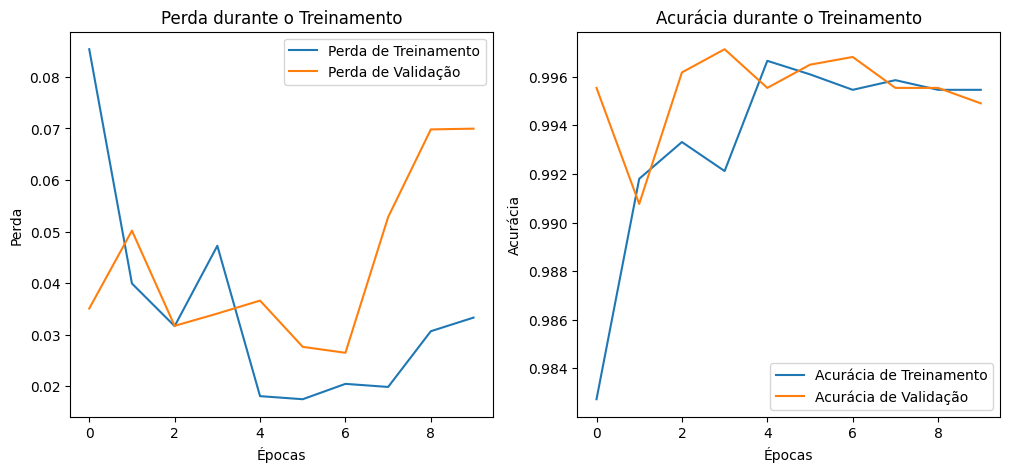

In [51]:
# Plotando a perda
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cloudy_history.history['loss'], label='Perda de Treinamento')
plt.plot(cloudy_history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Plotando a precisão
plt.subplot(1, 2, 2)
plt.plot(cloudy_history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(cloudy_history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

# Matriz de Confusão em Imagem

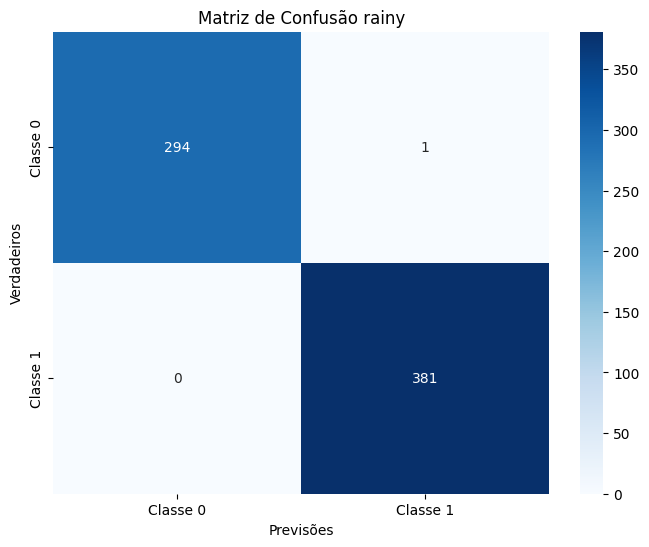

In [54]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(rainy_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsões')
plt.ylabel('Verdadeiros')
plt.title('Matriz de Confusão rainy')
plt.show()

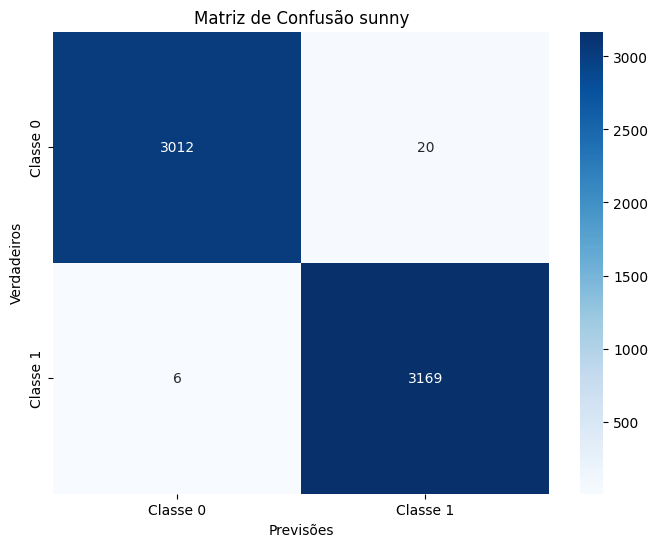

In [55]:


plt.figure(figsize=(8, 6))
sns.heatmap(sunny_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsões')
plt.ylabel('Verdadeiros')
plt.title('Matriz de Confusão sunny')
plt.show()

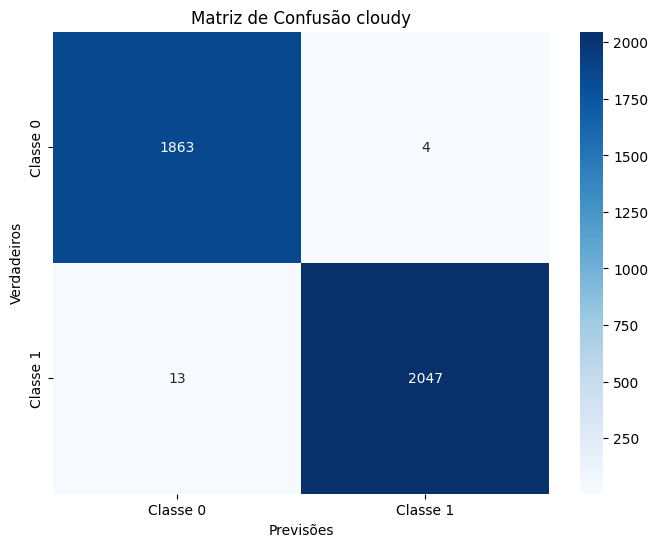

In [56]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cloudy_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsões')
plt.ylabel('Verdadeiros')
plt.title('Matriz de Confusão cloudy')
plt.show()

# Teste real do Modelo Completo

In [57]:
def visualizar_vagas2(imagem, coordenadas_vagas, classes_previstas):
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

    classes_previstas = np.squeeze(classes_previstas)  # Remove dimensões extras

    for i in range(len(coordenadas_vagas)):
        x, y, w, h = coordenadas_vagas[i]
        classe = classes_previstas[i] 
        cor = (0, 255, 0) if classe == 0 else (255, 0, 0)  # Verde se livre, vermelho se ocupado

        cv2.rectangle(imagem_rgb, (x, y), (x + w, y + h), cor, 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(imagem_rgb)
    plt.axis('off')
    plt.title('Detecção de Vagas')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


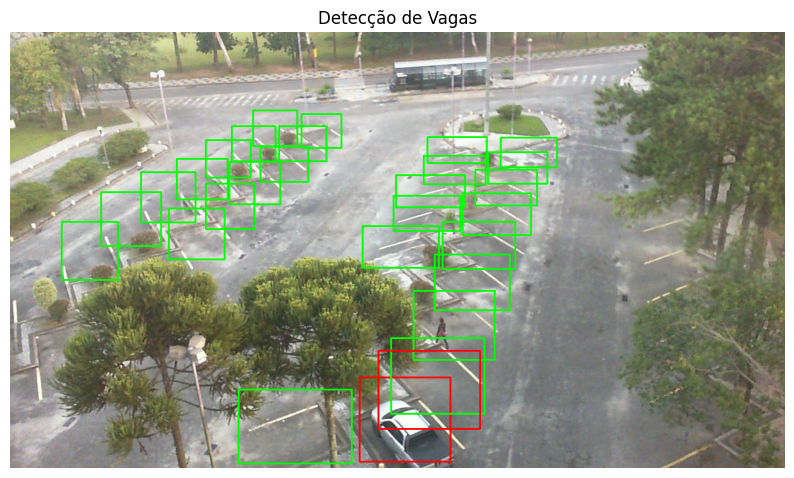

In [58]:

primeira_imagem = park_rainy_images[1]  
primeiras_coordenadas = rainy_coords[28:57]  


vagas_primeira_imagem = np.array(rainy_vagas[28:57])


primeiras_classes = model_rainy.predict(vagas_primeira_imagem)
y_pred_primeiras_classes = np.argmax(primeiras_classes, axis=1)  


visualizar_vagas2(primeira_imagem, primeiras_coordenadas, y_pred_primeiras_classes)

# Teste Real do Modelo em Vagas

In [59]:
def visualizar_vagas(imagem, classe):
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

    if classe == 1:
      titulo = 'Detecção de Vagas - Ocupada'
    else:
      titulo = 'Detecção de Vagas - Vazia'

    plt.figure(figsize=(5, 5))
    plt.imshow(imagem_rgb)
    plt.axis('off')
    plt.title(titulo)
    plt.show()


# Vagas - Clima Rainy (Chuvoso)

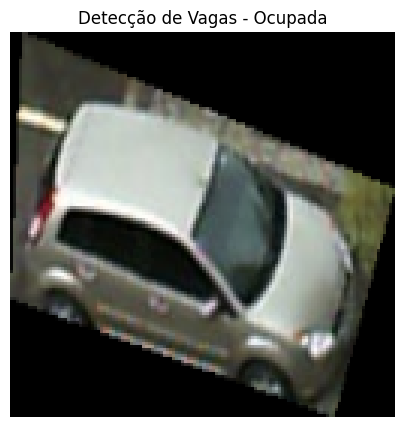

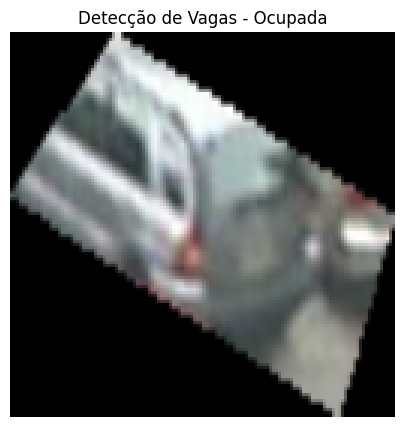

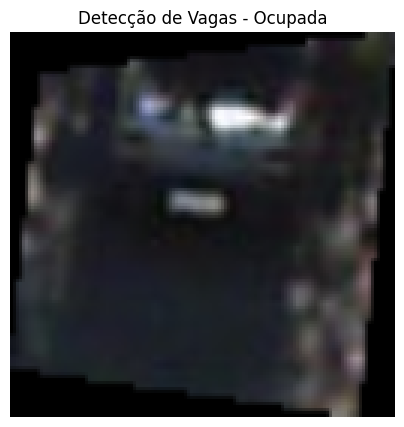

In [63]:
for i in range(3):
  imagem_plot = rainy_vagas[rainy_indices_test[i]]
  visualizar_vagas(imagem_plot, y_pred_rainy_classes[i])


# Vagas - Clima Sunny (Ensolarado)

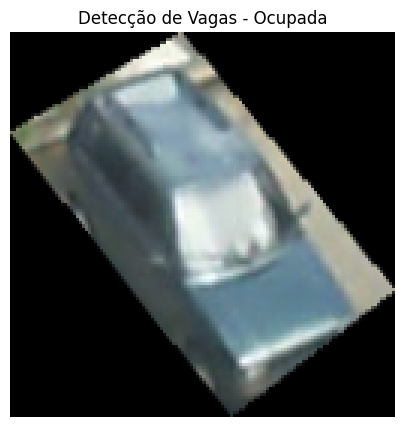

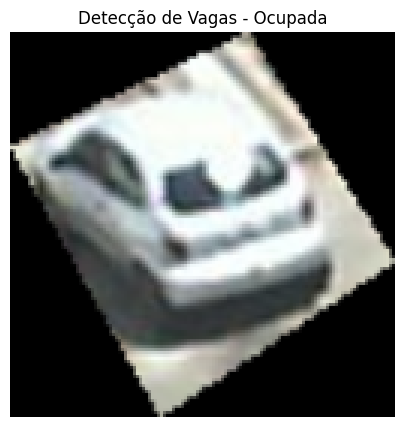

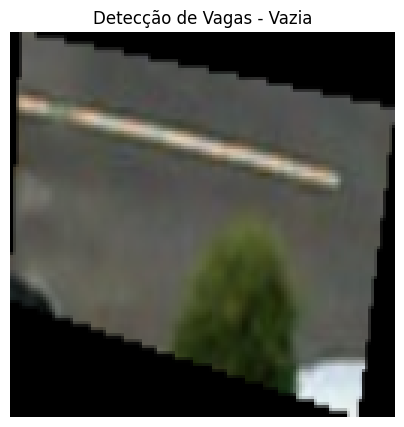

In [65]:
for i in range(3):
  imagem_plot = sunny_vagas[sunny_indices_test[i]]
  visualizar_vagas(imagem_plot, y_pred_sunny_classes[i])

# Vagas - Clima Cloudy (Nublado)

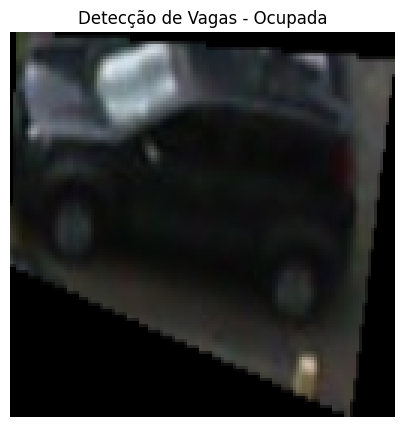

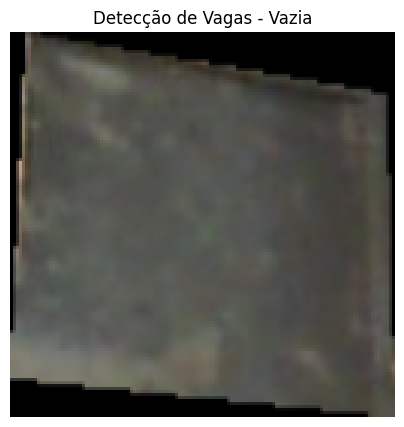

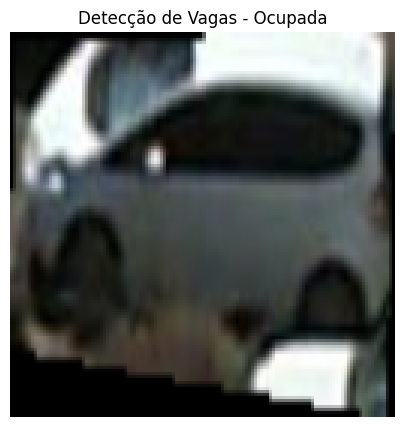

In [66]:
for i in range(3):
  imagem_plot = cloudy_vagas[cloudy_indices_test[i]]
  visualizar_vagas(imagem_plot, y_pred_cloudy_classes[i])